In [68]:
import pandas as pd
import datetime as dt
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [73]:
def ret_victory_home(row):
    if row['goal1'] > row['goal2']:
        return 'победа'
    elif row['goal1'] < row['goal2']:
        return 'поражение'
    else:
        return 'ничья'
    
def ret_victory_guest(row):
    if row['goal1'] > row['goal2']:
        return 'поражение'
    elif row['goal1'] < row['goal2']:
        return 'победа'
    else:
        return 'ничья'

Загружаем таблицы

In [232]:
countries = pd.read_csv('countries.csv')
players = pd.read_csv('players.csv')
events_df = pd.read_csv('events.csv')
lineups_df = pd.read_csv('lineups.csv')
games_df = pd.read_csv('games.csv')

Правим таблицы

In [201]:
countries.columns = ['country_id', 'country']
players.columns = ['num', 'name', 'team', 'birthdate', 'pos', 'country_id']
players = players.merge(countries, on='country_id')
players['birthdate'] = pd.to_datetime(players['birthdate'], format='%d-%m-%Y')
players['age'] = ((dt.datetime.now() - players['birthdate']).dt.days / 365).apply(np.floor)

In [225]:
games_df.head()

,game_id,date,group,team1,team2,goal1,goal2,description
0,0,14-6-2024,A,Германия,Шотландия,5,1,ЧЕ-2024 Группа A тур1
1,1,15-6-2024,A,Венгрия,Швейцария,1,3,ЧЕ-2024 Группа A тур1
2,2,15-6-2024,B,Испания,Хорватия,3,0,ЧЕ-2024 Группа B тур1


## Предварительная статистика

In [203]:
(players.
 pivot_table(index='team', values='num', aggfunc='count').
 sort_values(by='num', ascending=False).
 head(10)
)

,num
team,
Интер Милан,13
Манчестер Сити,13
Пари Сен-Жермен,12
Реал Мадрид,12
РБ Лейпциг,11
Барселона,11
Арсенал,10
Славия (Прага),10
Байер 04,10


### Возраст игроков

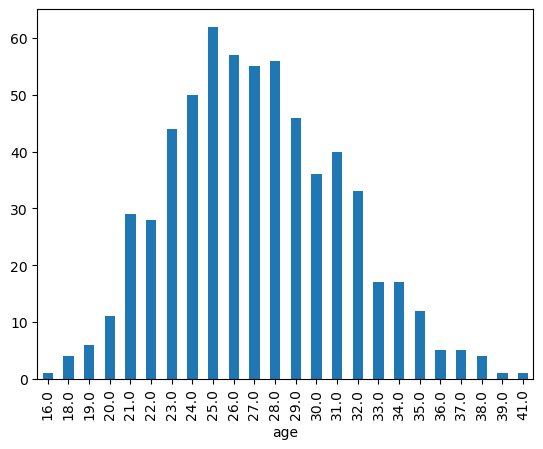

In [204]:
players.groupby('age')['num'].count().plot(kind='bar');

In [205]:
players['age'].describe()

count    620.000000
mean      27.112903
std        4.125279
min       16.000000
25%       24.000000
50%       27.000000
75%       30.000000
max       41.000000
Name: age, dtype: float64

Самые возрастные игроки

In [206]:
players.sort_values(by='birthdate').head(5)

,num,name,team,birthdate,pos,country_id,country,age
572,3,Пепе,Порту,1983-02-26,защ,23,Португалия,41.0
587,7,Криштиану Роналду,Ан-Наср (Эр-Рияд),1985-02-05,нап,23,Португалия,39.0
143,10,Лука Модрич,Реал Мадрид,1985-09-09,поз,6,Хорватия,38.0
113,22,Хесус Навас,Севилья,1985-11-21,защ,5,Испания,38.0
542,1,Георгий Лория,Динамо Тбилиси,1986-01-27,врт,22,Грузия,38.0


Самые молодые игроки

In [207]:
players.sort_values(by='birthdate', ascending=False).head(5)

,num,name,team,birthdate,pos,country_id,country,age
127,19,Ламин Ямаль,Барселона,2007-07-13,нап,5,Испания,16.0
403,18,Варрен Заир-Эмри,Пари Сен-Жермен,2006-03-08,поз,16,Франция,18.0
462,24,Лео Сауэр,Фейеноорд,2005-12-16,нап,18,Словакия,18.0
539,24,Семих Кылычсой,Бешикташ,2005-08-15,нап,21,Турция,18.0
559,26,Габриэль Сигуа,Базель,2005-06-30,поз,22,Грузия,18.0


Самые возрастные команды

In [208]:
players.pivot_table(index='country', values='age', aggfunc='mean').sort_values(by='age', ascending=False).head(5)

,age
country,
Германия,28.576923
Шотландия,28.307692
Польша,28.208333
Хорватия,27.730769
Дания,27.730769


Самые молодые команды

In [209]:
players.pivot_table(index='country', values='age', aggfunc='mean').sort_values(by='age').head(5)

,age
country,
Чехия,25.500000
Турция,25.807692
Англия,26.076923
Нидерланды,26.230769
Украина,26.384615


## Статистика турнира

### Средняя результативность матча

In [233]:
games_df['total_goals'] = games_df['goal1'] + games_df['goal2']
games_df['total_goals'].describe()

count    4.000000
mean     4.000000
std      1.414214
min      3.000000
25%      3.000000
50%      3.500000
75%      4.500000
max      6.000000
Name: total_goals, dtype: float64

### Бомбардиры

In [234]:
scorers = events_df[events_df['event'].isin(['гол','пенальти'])]
scorers.pivot_table(index='name', values='event', aggfunc='count')

,event
name,
Алессандро Бастони,1
Альваро Мората,1
Барнабаш Варга,1
Брель Эмболо,1
Дани Карвахаль,1
Джамал Мусиала,1
Кай Хаверц,1
Квадво Дуа,1
Мишель Эбишер,1


### Ассистены

In [235]:
assisters = events_df[events_df['event']=='пас']
assisters.pivot_table(index='name', values='event', aggfunc='count')

,event
name,
Доминик Собослаи,1
Йозуа Киммих,1
Кай Хаверц,1
Ламин Ямаль,1
Лоренцо Пеллегрини,1
Мишель Эбишер,1
Педри,1
Ремо Фройлер,1
Томас Мюллер,1


### Карточки

In [236]:
yellows = events_df[events_df['event']=='желтая карточка']
yellows.pivot_table(index='name', values='event', aggfunc='count')

,event
name,
Арбер Ходжа,1
Армандо Броя,1
Аттила Салаи,1
Бендегуз Болла,1
Джонатан Та,1
Лоренцо Пеллегрини,1
Ремо Фройлер,1
Риккардо Калафьори,1
Роберт Андрих,1


In [237]:
reds = events_df[events_df['event']=='красная карточка']
reds.pivot_table(index='name', values='event', aggfunc='count')

,event
name,
Райан Портеус,1


### Время игры

In [238]:
lineups_df['total'] = lineups_df['out'] - lineups_df['in']
lineups_df.pivot_table(index='name', values='total', aggfunc='sum').sort_values(by='total', ascending=False).head(20)

,total
name,
Джонатан Та,90
Вилли Орбан,90
Марин Понграчич,90
Скотт Мактоминей,90
Николо Барелла,90
Мануэль Нойер,90
Джек Хендри,90
Роланд Шаллаи,90
Мануэль Аканджи,90


## Старые игры

In [239]:
old_games = pd.read_csv('old_games.csv')
old_games.columns = ['game_id', 'date', 'team1', 'team2', 'goal1', 'goal2', 'description'] 
old_games['date'] = pd.to_datetime(old_games['date'], format='%d-%m-%Y')

In [240]:
old_games.head()

,game_id,date,team1,team2,goal1,goal2,description
0,0,2021-06-11,Турция,Италия,0,3,ЧЕ-2020 Группа A тур 1
1,1,2021-06-12,Уэльс,Швейцария,1,1,ЧЕ-2020 Группа A тур 1
2,2,2021-06-12,Дания,Финляндия,0,1,ЧЕ-2020 Группа B тур 1
3,3,2021-06-12,Бельгия,Россия,3,0,ЧЕ-2020 Группа B тур 1
4,4,2021-06-13,Англия,Хорватия,1,0,ЧЕ-2020 Группа D тур 1


**Введите названия команд**

In [241]:
team1='Италия'
team2='Албания'

**Игры между собой**

In [242]:
old_games.loc[((old_games['team1'] == team1) & (old_games['team2'] == team2)) 
              | ((old_games['team1'] == team2) & (old_games['team2'] == team1))]

,game_id,date,team1,team2,goal1,goal2,description


**Игры домашней команды**

In [243]:
team1h_df = old_games[old_games['team1'] == team1]
team1h_df['result'] = team1h_df.apply(ret_victory_home, axis=1)
team1h_pivot = team1h_df.pivot_table(index='result', values='game_id', aggfunc='count')
team1g_df = old_games[old_games['team2'] == team1]
team1g_df['result'] = team1g_df.apply(ret_victory_guest, axis=1)
team1_df = pd.concat([team1h_df, team1g_df],axis=0)
display(team1_df.sort_values(by='date',ascending=False))
team1g_pivot = team1g_df.pivot_table(index='result', values='game_id', aggfunc='count')
team1_pivot=team1h_pivot.merge(team1g_pivot, on='result', how='outer')
team1_pivot = team1_pivot.fillna(0)
team1_pivot['total'] = team1_pivot['game_id_x'] + team1_pivot['game_id_y']
team1_pivot.columns = ['home', 'guest', 'total']
team1_pivot[['home', 'guest', 'total']] = team1_pivot[['home', 'guest', 'total']].astype('int')
team1_pivot

,game_id,date,team1,team2,goal1,goal2,description,result
223,223,2023-11-20,Украина,Италия,0,0,квалификация ЧЕ-2024 группа C,ничья
221,221,2023-11-17,Италия,Северная Македония,5,2,квалификация ЧЕ-2024 группа C,победа
219,219,2023-10-17,Англия,Италия,3,1,квалификация ЧЕ-2024 группа C,поражение
217,217,2023-10-14,Италия,Мальта,4,0,квалификация ЧЕ-2024 группа C,победа
214,214,2023-09-12,Италия,Украина,2,1,квалификация ЧЕ-2024 группа C,победа
213,213,2023-09-09,Северная Македония,Италия,1,1,квалификация ЧЕ-2024 группа C,ничья
207,207,2023-03-26,Мальта,Италия,0,2,квалификация ЧЕ-2024 группа C,победа
205,205,2023-03-23,Италия,Англия,1,2,квалификация ЧЕ-2024 группа C,поражение
50,50,2021-07-11,Италия,Англия,1,1,пен 3 : 2 ЧЕ-2020 финал,ничья
48,48,2021-07-06,Италия,Испания,1,1,пен 4 : 2\tЧЕ-2020 1/2 финала,ничья


,home,guest,total
result,,,
ничья,4,6,10
победа,9,6,15
поражение,2,3,5


**Игры гостевой команды**

In [222]:
team2h_df = old_games[old_games['team1'] == team2]
team2h_df['result'] = team2h_df.apply(ret_victory_home, axis=1)
#display(team2h_df)
team2h_pivot = team2h_df.pivot_table(index='result', values='game_id', aggfunc='count')
team2g_df = old_games[old_games['team2'] == team2]
team2g_df['result'] = team2g_df.apply(ret_victory_guest, axis=1)
#display(team2g_df)
team2_df = pd.concat([team2h_df, team2g_df],axis=0)
display(team2_df.sort_values(by='date',ascending=False))
team2g_pivot = team2g_df.pivot_table(index='result', values='game_id', aggfunc='count')
team2_pivot=team2h_pivot.merge(team2g_pivot, on='result', how='outer')
team2_pivot = team2_pivot.fillna(0)
team2_pivot['total'] = team2_pivot['game_id_x'] + team2_pivot['game_id_y']
team2_pivot.columns = ['home', 'guest', 'total']
team2_pivot[['home', 'guest', 'total']] = team2_pivot[['home', 'guest', 'total']].astype('int')
team2_pivot

,game_id,date,team1,team2,goal1,goal2,description,result
262,262,2023-11-20,Албания,Фарерские острова,0,0,квалификация ЧЕ-2024 группа E,ничья
260,260,2023-11-17,Молдавия,Албания,1,1,квалификация ЧЕ-2024 группа E,ничья
257,257,2023-10-12,Албания,Чехия,3,0,квалификация ЧЕ-2024 группа E,победа
255,255,2023-09-10,Албания,Польша,2,0,квалификация ЧЕ-2024 группа E,победа
252,252,2023-09-07,Чехия,Албания,1,1,квалификация ЧЕ-2024 группа E,ничья
251,251,2023-06-20,Фарерские острова,Албания,1,3,квалификация ЧЕ-2024 группа E,победа
248,248,2023-06-17,Албания,Молдавия,2,0,квалификация ЧЕ-2024 группа E,победа
246,246,2023-03-27,Польша,Албания,1,0,квалификация ЧЕ-2024 группа E,поражение
56,56,2016-06-19,Румыния,Албания,0,1,ЧЕ-2016 Группа A тур 3,победа
54,54,2016-06-15,Франция,Албания,2,0,ЧЕ-2016 Группа A тур 2,поражение


,home,guest,total
result,,,
ничья,1,2,3
победа,3,2,5
поражение,1,2,3


### Разное

In [111]:
uteams = players['team'].unique()
uteams.sort()
uteams

array(['АЕК Афины', 'АПОЭЛ', 'Айнтрахт Франкфурт', 'Академия Пушкаша',
       'Алавес', 'Аланьяспор', 'Аль-Ахли (Джидда)', 'Аль-Иттифак',
       'Аль-Иттихад', 'Аль-Муайдар', 'Аль-Ухдуд', 'Аль-Хиляль',
       'Ан-Наср (Эр-Рияд)', 'Андерлехт', 'Антальяспор', 'Арсенал',
       'Асколи', 'Астон Вилла', 'Аталанта', 'Атланта Юнайтед',
       'Атлетик Бильбао', 'Атлетико Мадрид', 'Аугсбург',
       'Аш-Шабаб (Эр-Рияд)', 'Аякс', 'Бавария', 'Базель', 'Байер 04',
       'Бани Яс', 'Баник (Острава)', 'Бари', 'Барселона', 'Бенфика',
       'Бернли', 'Бешикташ', 'Боавишта', 'Болонья', 'Бордо', 'Борнмут',
       'Боруссия Дортмунд', 'Боруссия Мёнхенгладбах', 'Бохум',
       'Брайтон энд Хоув Альбион', 'Брентфорд', 'Бристоль Сити',
       'Брондбю', 'Брюгге', 'Будё-Глимт', 'Вайле', 'Валенсия', 'Вердер',
       'Вест Бромвич Альбион', 'Вест Хэм Юнайтед', 'Вестерло',
       'Виктория (Пльзень)', 'Вильярреал', 'Волунтари', 'Вольфсберг',
       'Вольфсбург', 'Вулверхэмптон Уондерерс', 'Гавр', 'Газиантеп

In [112]:
len(uteams)

219

In [101]:
players[players['team'].str.contains('Спартак Трнава')]

,num,name,team,birthdate,pos,country_id,country,age
227,25,Адриан Зелькович,Спартак Трнава,2002-08-19,поз,9,Словения,21.0
